In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import sys
sys.path.append('../') 
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary functions
from src.loader import load_data
from src.clean import clean_data

# Load data
sql_query = '''
    
 SELECT * FROM xdr_data
 '''

df = load_data(sql_query)


In [4]:
# apply the cleaning function
df = clean_data(df)

In [6]:
# RTT and TCP retransmissions are calculated per session, sum them up per user
df['Total TCP Retransmission (Bytes)'] = df['TCP DL Retrans. Vol (Bytes)'] + df['TCP UL Retrans. Vol (Bytes)']
df['Total Throughput (kbps)'] = df['Avg Bearer TP DL (kbps)'] + df['Avg Bearer TP UL (kbps)']

# Aggregate these new metrics per user
user_metrics = df.groupby('MSISDN/Number').agg({
    'Total TCP Retransmission (Bytes)': 'mean',
    'Total Throughput (kbps)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean'
}).reset_index()

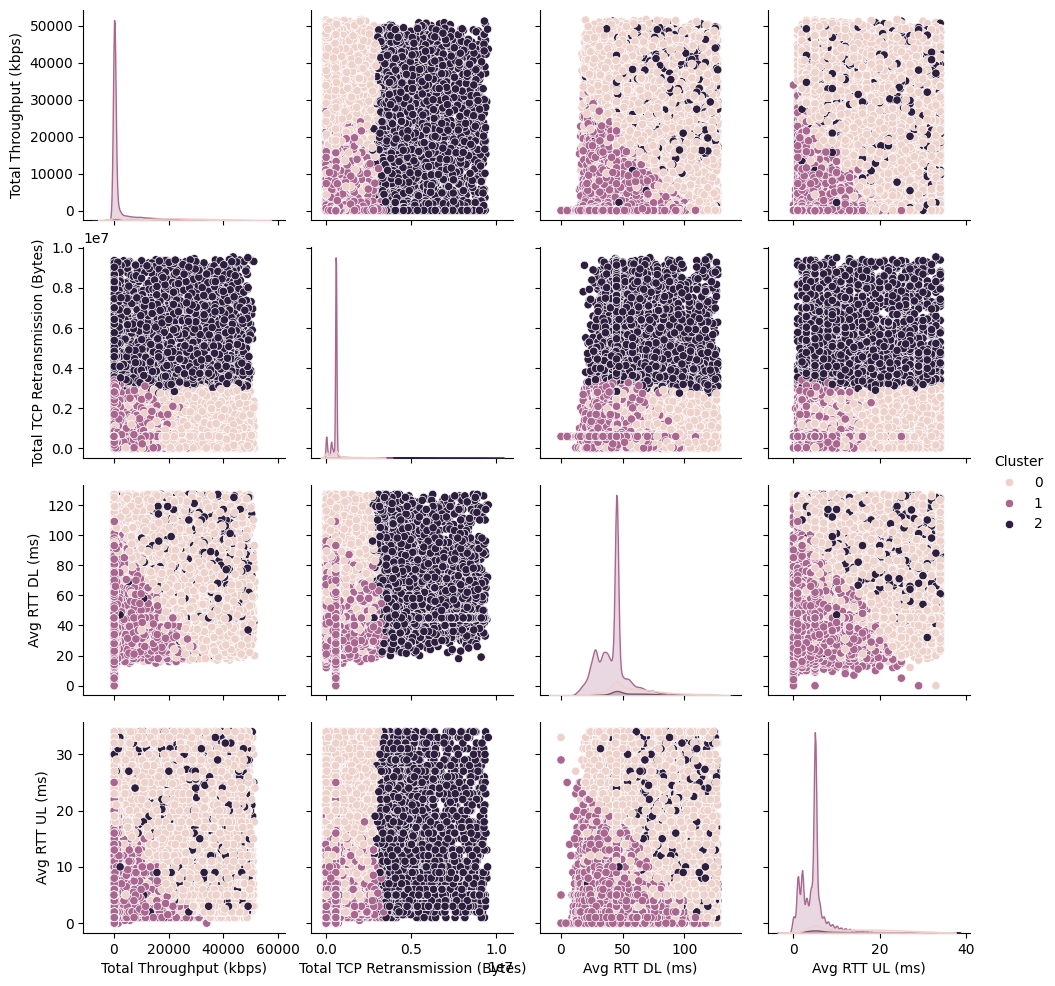

In [7]:
# Scaling the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_metrics[['Total Throughput (kbps)', 'Total TCP Retransmission (Bytes)', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)']])

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to your DataFrame
user_metrics['Cluster'] = clusters

# Visualize the clusters to understand their separation
sns.pairplot(user_metrics, hue='Cluster', vars=['Total Throughput (kbps)', 'Total TCP Retransmission (Bytes)', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)'])
plt.show()


In [9]:
# Calculate the mean for each cluster to understand its characteristics
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Avg Throughput', 'Avg TCP Retransmission', 'Avg RTT DL', 'Avg RTT UL'])
print(cluster_centers)

# Add descriptive interpretations as before
descriptions = {
    'Cluster 0': 'High Performance: This cluster represents users with high throughput and low TCP retransmissions and RTT, indicating a high-quality network experience.',
    'Cluster 1': 'Moderate Performance: Users in this cluster experience moderate throughput and moderate levels of TCP retransmissions and RTT, suggesting a fair but inconsistent experience.',
    'Cluster 2': 'Low Performance: This cluster includes users with the lowest throughput and the highest TCP retransmissions and RTT, reflecting a poor network experience.'
}

# Print descriptions for clarity
for cluster, description in descriptions.items():
    print(f"{cluster}: {description}")


   Avg Throughput  Avg TCP Retransmission  Avg RTT DL  Avg RTT UL
0    21813.097016            7.615680e+05   60.590746   14.179748
1     2036.540029            5.629243e+05   41.322781    4.592940
2    18016.716573            4.995120e+06   61.776699   12.396032
Cluster 0: High Performance: This cluster represents users with high throughput and low TCP retransmissions and RTT, indicating a high-quality network experience.
Cluster 1: Moderate Performance: Users in this cluster experience moderate throughput and moderate levels of TCP retransmissions and RTT, suggesting a fair but inconsistent experience.
Cluster 2: Low Performance: This cluster includes users with the lowest throughput and the highest TCP retransmissions and RTT, reflecting a poor network experience.
